# Export a ready made mesh for fenics with HIVE

In [1]:
#from fenics import *
from dolfin import *
from dolfin import HDF5File
from scipy.spatial import KDTree
import numpy as np

# Create a new low fidelity mesh from the dat file

In [2]:
def parse_dat_file_for_tetrahedra(filename):
    nodes = []
    tetrahedra = []
    with open(filename, 'r') as file:
        num_nodes, num_elements = map(int, file.readline().strip().split()) # Read number of nodes and elements from the first line

        # Read nodal coordinates
        for _ in range(num_nodes):
            line = file.readline().strip().split()
            node = list(map(float, line[1:]))
            nodes.append(node)

        # Skip potential empty line before element connectivity
        next(file)

        # Read element connectivity, focusing on lines with 4 node indices
        for _ in range(num_elements):
            line = file.readline().strip().split()
            if len(line) == 6:  # Assuming the lines with 4 node indices have 6 columns in total
                element = list(map(int, line[2:]))  # Adjust if necessary
                tetrahedra.append(element)

    return nodes, tetrahedra



In [3]:
# We are only extracting the tetrahedral elements to get a viable solution which is not too accurate
mesh  = parse_dat_file_for_tetrahedra('output/Sample.dat')
#mesh  = parse_dat_file_for_tetrahedra('output/Sample.dat')

nodes, elements = mesh # mesh is a tuple with two lists: nodal coordinates and tetrahedral connectivity

In [4]:
# Create a Mesh
mesh = Mesh()
editor = MeshEditor()
editor.open(mesh, "tetrahedron", 3, 3)  # 3D tetrahedral mesh

# Add vertices
editor.init_vertices(len(nodes))
for i, node in enumerate(nodes):
    editor.add_vertex(i, node)

# Add tetrahedra
editor.init_cells(len(elements))
for i, element in enumerate(elements):
    editor.add_cell(i, np.array(element) - 1)  # Subtract 1 if indices are 1-based

editor.close()


In [5]:
# Open this xdmf file in Paraview to visualize the mesh
with XDMFFile("output/new_mesh.xdmf") as file:
    file.write(mesh)

# Create Boundary Mesh from boundary dat files
Understanding your situation and considering the format of your boundary condition (BC) nodal coordinates matches that of your full mesh, there are two primary approaches to apply BCs in FEniCS based on your data:

Approach 1: Direct Matching of Nodal Coordinates
Since the nodal coordinates in your BC data files should exactly match those in your full mesh, you can use a direct comparison approach. This method is straightforward if every node in your BC data corresponds exactly to nodes in the mesh without any numerical precision issues.

Plan for Direct Matching:
* Parse BC Files: Read the nodal coordinates for your BCs from the DAT files, similar to how you've parsed your full mesh data.
* Identify Matching Nodes: Iterate through the nodes in your mesh and mark those that match the BC nodal coordinates exactly.
* Apply BCs: Use the marked nodes to define where your boundary conditions should be applied in FEniCS.
This method relies on exact matches, which can sometimes be problematic due to floating-point representation and precision issues in numerical computations. If all coordinates are guaranteed to match exactly and you do not encounter precision issues, this could work well.

Approach 2: Proximity-Based Matching (as previously described)
A more flexible and probably more robust approach involves using a proximity search to identify nodes in the mesh that are "close enough" to the BC nodal coordinates, accounting for potential numerical precision differences.

Plan for Proximity-Based Matching:
* Parse BC Files: Same as in the direct matching approach.
* Create a KDTree for Efficient Search: Use a KDTree or similar spatial data structure to facilitate efficient nearest-neighbor searches within your mesh coordinates.
* Identify Close Nodes: For each node in your BC data, find the closest node in the mesh using the KDTree. This step mitigates issues with slight numerical differences.
* Apply BCs: Define boundary conditions based on the identified nodes or elements.
* Why Proximity-Based Might Be Better:
* Robustness to Numerical Precision Issues: Even minor differences in floating-point representation won't prevent identifying the correct mesh nodes for applying BCs.
* Flexibility: Easier to adapt if the BC nodal coordinates don't exactly match due to mesh refinement or alterations in the geometry.


In [6]:
# extract the coordinates only of the top tile and the pipe face
# we will later use these coordinates to match nodes on mesh using scipy KDTree

top_tile_coords, _ = parse_dat_file_for_tetrahedra('output/TileTop.dat')
pipeface_coords, _ = parse_dat_file_for_tetrahedra('output/PipeFace.dat')


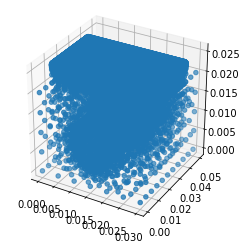

In [7]:
import matplotlib.pyplot as plt 
ax = plt.axes(projection='3d')
ax.scatter(*zip(*nodes))
ax.set_box_aspect([1,1,1])

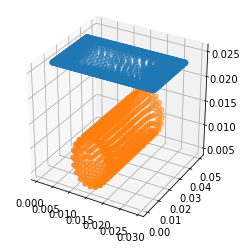

In [8]:
import matplotlib.pyplot as plt 
ax = plt.axes(projection='3d')
ax.scatter(*zip(*top_tile_coords))
ax.scatter(*zip(*pipeface_coords))

ax.set_box_aspect([1,1,1])
plt.camera_position = (0, 0, 0)

In [9]:
len(top_tile_coords), len(pipeface_coords)

(3108, 749)

Identifying Boundary Mesh Entities
* You'll need to find which vertices in your mesh correspond to these BC nodal coordinates. One approach is to mark these vertices using a MeshFunction over the boundary:

In [10]:
tolerance = 1E-3
top_tile_vertices = []
pipeface_vertices = []

# Use mesh.coordinates() for KDTree and query each BC coordinate
tree = KDTree(mesh.coordinates())

# Find and mark the vertices close to the BC nodal coordinates
for bc_coords, marker_list in zip([top_tile_coords, pipeface_coords], [top_tile_vertices, pipeface_vertices]):
    for coord in bc_coords:
        distance, vertex_index = tree.query(coord)
        if distance < tolerance:
            # Ensure the vertex index is unique before adding
            if vertex_index not in marker_list:
                marker_list.append(vertex_index)

# Now, `top_tile_vertices` and `pipeface_vertices` contain indices of vertices
# close to your BCs based on your provided tolerance.
boundary_markers = MeshFunction('size_t', mesh, mesh.topology().dim()-1, 0)

In [11]:
len(top_tile_vertices), len(pipeface_vertices)

(3108, 749)

In [15]:
# Convert vertex lists to sets for faster lookup
top_tile_vertex_set = set(top_tile_vertices)
pipeface_vertex_set = set(pipeface_vertices)

# Mark facets based on the identified vertices
for f in facets(mesh):
    # Get the global indices of the vertices for each facet
    facet_vertex_indices = [vertex.index() for vertex in vertices(f)]
    # If any of the facet's vertices are in top_tile_vertex_set, mark the facet
    if any(v_idx in top_tile_vertex_set for v_idx in facet_vertex_indices):
        boundary_markers[f] = 1  # Assuming '1' is the marker for top tile
    # Similarly for pipeface_vertex_set
    elif any(v_idx in pipeface_vertex_set for v_idx in facet_vertex_indices):
        boundary_markers[f] = 2  # Assuming '2' is the marker for pipeface


In [16]:
# Assume 'mesh' is your Mesh object and 'boundary_markers' is a MeshFunction marking the BCs

# Save the mesh
with XDMFFile(MPI.comm_world, "output/mesh_with_bcs.xdmf") as file:
    file.write(mesh)

# Save the boundary markers
with XDMFFile(MPI.comm_world, "output/boundary_markers.xdmf") as file:
    file.write(boundary_markers)


In [17]:
# To visualise the BC for sanity check
import pyvista as pv

In [18]:
# Assuming 'mesh' is your FEniCS mesh object and 'top_tile_vertices' + 'pipeface_vertices' are lists of vertex indices
coords = mesh.coordinates()

# Combine your marked vertices
all_marked_vertices = np.array(list(set(top_tile_vertices + pipeface_vertices)))

# Extract their coordinates
points = coords[all_marked_vertices]

# Create a PyVista mesh of points
point_cloud = pv.PolyData(points)

# Save to file
point_cloud.save("output/marked_vertices.vtk")